In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

In [2]:
# load data 
def get_data(target):
    target = target.upper()
    df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
    
    # Prediction O/U
    if(target == 'OU_RESULT'): # Classification
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        task = 'classification'
    if(target == 'OU_LINE'): # Regression
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        df['OU_LINE'] = df['ou_line']
        df['FINAL_OU'] = df['score1'] + df['score2']
        task = 'regression'
        target = 'FINAL_OU'
        
    if('OU' in target):
        df = df.dropna(subset=[target])
        df = df[df['OU_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['OU_LINE', 'OU_RESULT']
        
    if(target == 'SPREAD_RESULT'): # Classification
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        task = 'classification'
    if(target == 'SPREAD'): # Regression
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        df['SPREAD'] = df['spread']
        df['FINAL_SPREAD'] = df['score1'] - df['score2']
        task = 'regression'
        target = 'FINAL_SPREAD'

    if('SPREAD' in target):
        df = df.dropna(subset=[target])
        df = df[df['SPREAD_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['SPREAD', 'SPREAD_RESULT']
    
    return df, target.upper(), outcome, task


In [3]:
def get_columns(df, target):
    game_data_columns = []
    for c in df.columns:
        if("home" in c or "away" in c):
            if('td' not in c and 'xp' not in c and 'fg' not in c and 'poss' not in c and 'down' not in c and target not in c):
                game_data_columns.append(c)

    return df[game_data_columns]

In [10]:
# Create a dataset that pytorch loader can work with 
class NFLClassificationDataset(Dataset):
    def __init__(self, dataframe, target, features, task='classification', outcome=None):
        self.features = features
        self.target = target
        if(task == 'classification'):
            self.y = torch.tensor(dataframe[target].values).long()
            self.outcome = torch.tensor(dataframe[target].values).long()
        else:
            self.y = torch.tensor(dataframe[target].values).float()
            self.outcome = torch.tensor(dataframe[outcome].values).float()

        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
def split_data(df, target, task, year=2020, outcome=None):
    '''
        Uses single year as validaion year. Previous years are train, future years are test
    '''
    df_train = benchmark_data[df['year'] <= year].copy()
    df_val = benchmark_data[df['year'] == year].copy()
    df_test = benchmark_data[df['year'] > year].copy()
    
    df_train[target] = df[df['year'] < year][target]
    df_val[target] = df[df['year'] == year][target]
    df_test[target] = df[df['year'] > year][target]

    for c in df_train.columns:
        if(task == 'classification' and c == target):
            continue
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_val[c] = (df_val[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
    
    df_train = df_train.dropna(subset=[target])
    df_val = df_val.dropna(subset=[target])
    df_test = df_test.dropna(subset=[target])
    
    if(outcome is not None):
        df_train[outcome] = df[df['year'] < year][outcome]
        df_val[outcome] = df[df['year'] == year][outcome]
        df_test[outcome] = df[df['year'] > year][outcome]
        
        mean = df_train[outcome[0]].mean()
        std = df_train[outcome[0]].std()
        
        df_train[outcome[0]] = (df_train[outcome[0]] - mean)/std
        df_val[outcome[0]] = (df_val[outcome[0]] - mean)/std
        df_test[outcome[0]] = (df_test[outcome[0]] - mean)/std

    
    return df_train, df_val, df_test

def get_data_loaders(df_train, df_val, df_test, target, task, batch_size=32, outcome=None):
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features, task=task, outcome=outcome)
    val_dataset = NFLClassificationDataset(df_val, target=target, features=features, task=task, outcome=outcome)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features, task=task, outcome=outcome)
    
    # Set the dataset in pytorch dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [6]:
# Training 
def train(data, model, loss_func, optimizer, task):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        if(task=='classification'):
            loss = loss_func(output, y)
        if(task=='regression'):
            loss = loss_func(output, y[:,np.newaxis])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    return mean_loss, model
    

def test(data, model, loss_func, task):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output = model(x)
            if(task == 'classification'):
                total_loss += loss_func(output,y).item()
            else:
                total_loss += loss_func(output,y[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    
    return mean_loss   

# prediction function
def predict(data, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    return output

In [7]:
def evaluate(data, model):
    preds, labels = torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        for x, y in data:
            labels = torch.cat((labels, y))
            preds = torch.cat((preds, torch.argmax(model(x[np.newaxis]), dim=2)[0]))            
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

def classification_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        for x, y in test_loader:
            pred = model(x)
            pred_label = torch.argmax(model(x), dim=1)
            for i in range(len(pred)):
                if(pred[i][pred_label[i]] > threshold):
                    if(pred_label[i] == y[i]):
                        good_bet += 1
                        money += 90.91
                    else:
                        bad_bet += 1
                        money -= 100
                total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games


def regression_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        preds, ou_preds = torch.Tensor([]), torch.Tensor([])
        
        # Get predictions
        for x, y in test_loader:
            pred = model(x)
            preds = torch.cat((preds, pred[:,0]))

        # Check if prediction is bigger or smaller than line
        outcome = test_loader.dataset.outcome
        meets_threshold, ou_preds = [], []
        for i in range(len(preds)):
            meets_threshold.append((preds[i] - outcome[i][0]).abs() > threshold)
            ou_preds.append(preds[i] > outcome[i][0])

        for i in range(len(ou_preds)):
            if(meets_threshold[i]):
                if(ou_preds[i] == outcome[i][1]):
                    good_bet += 1
                    money += 90.91
                else:
                    bad_bet += 1
                    money -= 100
            total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games

## Put it all together

311 8 10


100%|████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.70it/s]


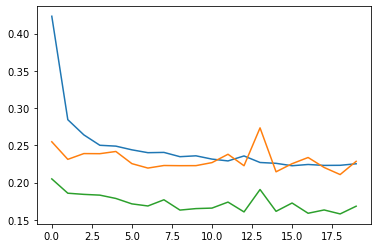

THRESHOLD: 1.0
GOOD BETS: 72	BAD BETS: 68
MONEY MADE: -254.48 BETTING ON 57.14% OF GAMES


In [137]:
# Get data    
target = 'ou_line'
df, target, outcome, task = get_data(target)
benchmark_data = get_columns(df, target)

df_train, df_val, df_test = split_data(df, target, task, outcome=outcome)
df_train = df_train.dropna()

train_loader, val_loader, test_loader = get_data_loaders(
                                            df_train,
                                            df_val,
                                            df_test, 
                                            target,
                                            task,
                                            batch_size=32,
                                            outcome=outcome)

thresholds = np.linspace(0.5, 1.0, 51)
money_made = []
games_bet = []

# hyperparameters
lr = 1e-3
epoch = 20
input_size = len(list(df_train.columns.difference([target])))
hidden_size = 64
dropout = 0.2

if(task == 'classification'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,2),
        nn.Softmax(dim=1)
    )
    loss_func = nn.CrossEntropyLoss()
elif(task == 'regression'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,1),
    )
    loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Run lstm 
trainloss = []
testloss = []
valloss = []
print(len(train_loader), len(val_loader), len(test_loader))
for i in tqdm(range(epoch)):
    train_loss, model = train(train_loader, model, loss_func, optimizer=optimizer, task=task)
    trainloss.append(train_loss)

    val_loss = test(val_loader, model, loss_func, task=task)
    valloss.append(val_loss)

    test_loss  = test(test_loader, model, loss_func, task=task)
    testloss.append(test_loss)    

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(valloss)
ax.plot(testloss)
plt.show()

if(task == 'classification'):
    val_accuracy = evaluate(val_loader, model)
    test_accuracy = evaluate(test_loader, model)
    result = classification_betting_result(model, val_loader, threshold=0.7)
    money_made.append(result[0])
    games_bet.append(result[1])
elif(task == 'regression'):
    result = regression_betting_result(model, val_loader, threshold=1.)
    money_made.append(result[0])
    games_bet.append(result[1])
        
#fig, ax = plt.subplots(ncols=2, figsize=(15,6))
#ax[0].plot(thresholds, money_made)
#ax[1].plot(thresholds, games_bet)
#plt.show()

## LSTM 

In [179]:
# load data 
def get_lstm_data(target):
    target = target.upper()
    df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
    df = df[df['season'] >= 1979]
    #TODO: Still need to shift data

    # Prediction O/U
    if(target == 'OU_RESULT'): # Classification
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        task = 'classification'
    if(target == 'OU_LINE'): # Regression
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        df['OU_LINE'] = df['ou_line']
        df['FINAL_OU'] = df['score1'] + df['score2']
        task = 'regression'
        target = 'FINAL_OU'
        
    if('OU' in target):
        df = df.dropna(subset=[target])
        df = df[df['OU_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['OU_LINE', 'OU_RESULT']
        
    if(target == 'SPREAD_RESULT'): # Classification
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        task = 'classification'
    if(target == 'SPREAD'): # Regression
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        df['SPREAD'] = df['spread']
        df['FINAL_SPREAD'] = df['score1'] - df['score2']
        task = 'regression'
        target = 'FINAL_SPREAD'

    if('SPREAD' in target):
        df = df.dropna(subset=[target])
        df = df[df['SPREAD_RESULT'] != 2]
        outcome = None if(task == 'classification') else ['SPREAD', 'SPREAD_RESULT']
        
    return df, target.upper(), outcome, task

In [180]:
class NFLSingleTeamData(Dataset):
    def __init__(self, dataframe, target, features, task='classification', outcome=None):
        self.features = features
        self.target = target
        if(task == 'classification'):
            self.y = torch.tensor(dataframe[target].values).long()
            self.outcome = torch.tensor(dataframe[target].values).long()
        else:
            self.y = torch.tensor(dataframe[target].values).float()
            self.outcome = torch.tensor(dataframe[outcome].values).float()

        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [238]:
# model 
class SeasonRegressionLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super(SeasonRegressionLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size, 
                            num_layers = self.num_layers, 
                            dropout = self.dropout, 
                            batch_first = True).cuda()
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=output_size).cuda()
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().cuda()
        
        outs, (hn, cn) = self.lstm(x,(h0,c0))
        out = self.linear(outs)
        
        return out 

In [239]:
def split_lstm_data(df, target, task, year=2020, outcome=None):
    '''
        Uses single year as validaion year. Previous years are train, future years are test
    '''
    df_train = benchmark_data[df['season'] <= year].copy()
    df_val = benchmark_data[df['season'] == year].copy()
    df_test = benchmark_data[df['season'] > year].copy()
    
    df_train[target] = df[df['season'] < year][target]
    df_val[target] = df[df['season'] == year][target]
    df_test[target] = df[df['season'] > year][target]

    for c in df_train.columns:
        if(task == 'classification' and c == target):
            continue
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_val[c] = (df_val[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
    
    df_train = df_train.dropna(subset=[target])
    df_val = df_val.dropna(subset=[target])
    df_test = df_test.dropna(subset=[target])
    
    if(outcome is not None):
        df_train[outcome] = df[df['season'] < year][outcome]
        df_val[outcome] = df[df['season'] == year][outcome]
        df_test[outcome] = df[df['season'] > year][outcome]
        
        mean = df_train[outcome[0]].mean()
        std = df_train[outcome[0]].std()
        
        df_train[outcome[0]] = (df_train[outcome[0]] - mean)/std
        df_val[outcome[0]] = (df_val[outcome[0]] - mean)/std
        df_test[outcome[0]] = (df_test[outcome[0]] - mean)/std

    
    return df_train, df_val, df_test

def get_lstm_data_loaders(df, df_train, df_val, df_test, target, task, batch_size=4, outcome=None, year=2020):
    features = list(df_train.columns.difference([target]))
    train_data, val_data, test_data = [], [], []
    for season, games in df.groupby("season"):
        # Need each team's games for each season, which becomes an NFLSingleTeamData object
        for team in games['team1'].unique():
            if(season < year):
                team_season = df_train.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                train_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
            elif(season == year):
                team_season = df_val.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                val_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
            else:
                team_season = df_test.loc[games[(games["team1"] == team) | (games["team2"] == team)].index]
                test_data.append(NFLSingleTeamData(team_season, target=target, features=features, task=task, outcome=outcome))
                
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_data, val_data, test_data

In [242]:
# Training 
def train_lstm(data, model, loss_func, optimizer, task):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for d in data:
        output = model(d.X.cuda())
        if(task=='classification'):
            #print(d.y.shape)
            #print(output.shape)
            loss = loss_func(output, d.y.cuda())
        if(task=='regression'):
            loss = loss_func(output, d.y[:,np.newaxis].cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    return mean_loss, model
    

def test_lstm(data, model, loss_func, task):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for d in data:
            output = model(d.X.cuda())
            if(task == 'classification'):
                total_loss += loss_func(output,d.y.cuda()).item()
            else:
                total_loss += loss_func(output,d.y.cuda()[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    
    return mean_loss   

# prediction function
def predict_lstm(data, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for d in data:
            y_fit = model(d.X.cuda()).detach()
            output = torch.cat((output,y_fit), 0)
    return output

In [293]:
def evaluate_lstm(data, model):
    preds, labels = torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        for d in data:
            labels = torch.cat((labels, d.y))
            preds = torch.cat((preds, torch.argmax(model(d.X.cuda()).cpu(), dim=1)))            
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

def classification_betting_result_lstm(model, test_loader, threshold=0.6):
    # Need to filter out duplicates somehow
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        for d in test_loader:
            pred = model(d.X.cuda()).cpu()
            pred_label = torch.argmax(model(d.X.cuda()).cpu(), dim=1)
            for i in range(len(pred)):
                if(pred[i][pred_label[i]] > threshold):
                    if(pred_label[i] == d.y[i]):
                        good_bet += 1
                        money += 90.91
                    else:
                        bad_bet += 1
                        money -= 100
                total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games


def regression_betting_result_lstm(model, test_loader, threshold=0.6):
    # Need to filter out duplicates somehow
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        preds, ou_preds = torch.Tensor([]), torch.Tensor([])
        
        # Get predictions
        for d in test_loader:
            pred = model(d.X.cuda()).cpu()
            preds = torch.cat((preds, pred[:,0]))

        # Check if prediction is bigger or smaller than line
        outcome = torch.Tensor([])
        for d in test_loader:
            outcome = torch.cat((outcome, d.outcome))

        meets_threshold, ou_preds = [], []
        for i in range(len(preds)):
            meets_threshold.append((preds[i] - outcome[i][0]).abs() > threshold)
            ou_preds.append(preds[i] > outcome[i][0])
            
        for i in range(len(ou_preds)):
            if(meets_threshold[i]):
                if(ou_preds[i] == outcome[i][1]):
                    good_bet += 1
                    money += 90.91
                else:
                    bad_bet += 1
                    money -= 100
            total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games

1237 32 32


100%|████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]


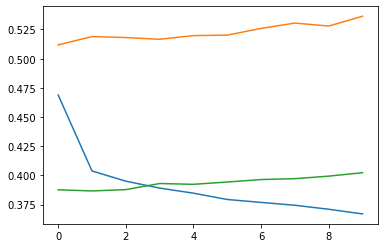

CLASSIFICATION ACCURACY: 77.068%
CLASSIFICATION ACCURACY: 81.250%
THRESHOLD: 0.7
GOOD BETS: 325	BAD BETS: 64
MONEY MADE: 23145.75 BETTING ON 73.12% OF GAMES


In [298]:
# Get data
target = 'spread_result' # One of: spread, spread_result, ou_line, ou_result
df, target, outcome, task = get_lstm_data(target)
benchmark_data = get_columns(df, target)

df_train, df_val, df_test = split_lstm_data(df, target, task, outcome=outcome)
df_train = df_train.dropna()

train_loader, val_loader, test_loader = get_lstm_data_loaders(
                                            df,
                                            df_train,
                                            df_val,
                                            df_test, 
                                            target,
                                            task,
                                            batch_size=1,
                                            outcome=outcome)

thresholds = np.linspace(0.5, 1.0, 51)
money_made = []
games_bet = []

# hyperparameters
# hyperparameters
lr = 1e-3
epoch = 10
input_size = len(df_train.columns)-1
hidden_size = 16
num_layers = 3
dropout = 0.1

model = SeasonRegressionLSTM(
                       input_size=input_size,
                       output_size=1 if(task == 'regression') else 2,
                       hidden_size=hidden_size, 
                       num_layers= num_layers,
                       dropout= dropout
                      ).cuda()
loss_func = nn.CrossEntropyLoss() if(task == 'classification') else nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Run lstm 
trainloss = []
testloss = []
valloss = []
print(len(train_loader), len(val_loader), len(test_loader))
for i in tqdm(range(epoch)):
    train_loss, model = train_lstm(train_loader, model, loss_func, optimizer=optimizer, task=task)
    trainloss.append(train_loss)

    val_loss = test_lstm(val_loader, model, loss_func, task=task)
    valloss.append(val_loss)

    test_loss  = test_lstm(test_loader, model, loss_func, task=task)
    testloss.append(test_loss)    

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(valloss)
ax.plot(testloss)
plt.show()

if(task == 'classification'):
    val_accuracy = evaluate_lstm(val_loader, model)
    test_accuracy = evaluate_lstm(test_loader, model)
    result = classification_betting_result_lstm(model, val_loader, threshold=0.7)
    money_made.append(result[0])
    games_bet.append(result[1])
elif(task == 'regression'):
    result = regression_betting_result_lstm(model, val_loader, threshold=1.)
    money_made.append(result[0])
    games_bet.append(result[1])